In [22]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

In [1]:
# Required libraries
import dowhy
from dowhy import CausalModel
import dowhy.datasets

# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True,
    stddev_treatment_noise=10)

In [2]:
# I. Create a causal model from the data and domain knowledge.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    instruments=data["instrument_names"])

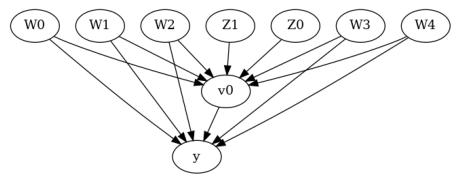

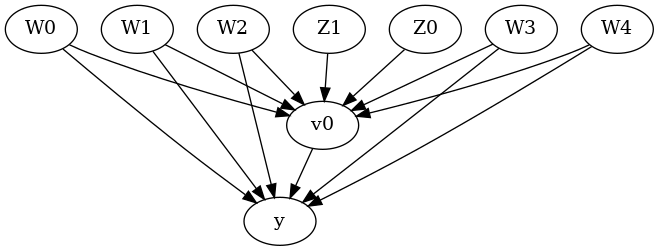

In [3]:
model.view_model(layout="dot")
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

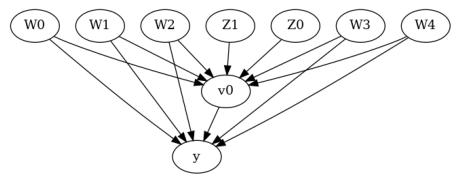

In [4]:
# I. Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"][0],
    outcome=data["outcome_name"][0],
    graph=data["gml_graph"])
model.view_model(layout="dot")

In [5]:
# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W1,W3,W0,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,W4,U) = P(y|v0,W2,W1,W3,W0,W4)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [6]:
# III. Estimate the target estimand using a statistical method.
propensity_strat_estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.dowhy.propensity_score_stratification")

print(propensity_strat_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W1,W3,W0,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W1,W3,W0,W4,U) = P(y|v0,W2,W1,W3,W0,W4)

## Realized estimand
b: y~v0+W2+W1+W3+W0+W4
Target units: ate

## Estimate
Mean value: 9.950061901233155



In [23]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand,
                                    method_name="backdoor.econml.dml.DML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[Outcome|w1,w0])
d[Treatment]                  
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w1,w0,U) = P(Outcome|Treatment,w1,w0)

## Realized estimand
b: Outcome~Treatment+w1+w0 | 
Target units: ate

## Estimate
Mean value: 1.0895452329337318
Effect estimates: [[1.08954523]]



In [8]:
# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, propensity_strat_estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)

Refute: Use a Placebo Treatment
Estimated effect:9.950061901233155
New effect:0.0007797590498245119
p value:0.98



<h1>1 Mistery Dataset</h1>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy.datasets, dowhy.plotter

   Treatment    Outcome        w0         s        w1
0   7.676622  14.917138  1.284371  4.647917 -0.784026
1  14.514999  28.562248  2.933088  4.032914 -0.704366
2   6.097971  12.373387  0.129304  9.032069  0.617531
3  26.627815  53.543646  4.484707  9.912852  1.620577
4  12.221022  24.299953 -2.520936  5.783832 -1.242804


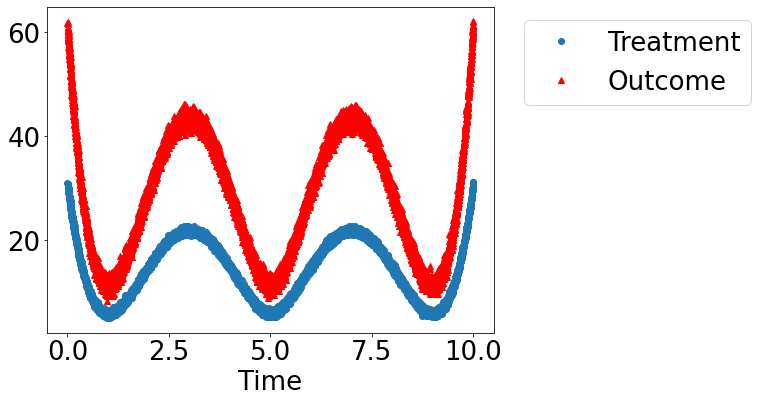

In [10]:
rvar = 1 if np.random.uniform() > 0.2 else 0
is_linear = False # A non-linear dataset. Change to True to see results for a linear dataset.
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar,
                                      num_common_causes=2,
                                      is_linear=is_linear,
                                      sd_error=0.2)
df = data_dict['df']
print(df.head())
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]].values, df[data_dict["outcome_name"]].values,
                             df[data_dict["time_val"]].values)

In [26]:
print(data_dict["treatment_name"])
print(data_dict["outcome_name"])
print(data_dict["common_causes_names"])
print(data_dict["instrument_names"])

Treatment
Outcome
['w0', 'w1']
None


<h2>1.1 Model assumptions about the data-generating process using a causal graph</h2>

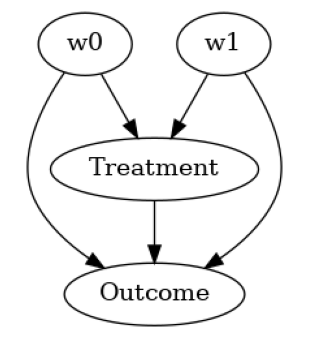

In [11]:
model= CausalModel(
        data=df,
        treatment=data_dict["treatment_name"],
        outcome=data_dict["outcome_name"],
        common_causes=data_dict["common_causes_names"],
        instruments=data_dict["instrument_names"])
model.view_model(layout="dot")

<h2>1.2 Identify the correct estimand for the target quantity based on the causal model</h2>

In [12]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[Outcome|w1,w0])
d[Treatment]                  
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w1,w0,U) = P(Outcome|Treatment,w1,w0)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



<h2>1.3 Estimate the target estimand </h2>

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[Outcome|w1,w0])
d[Treatment]                  
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w1,w0,U) = P(Outcome|Treatment,w1,w0)

## Realized estimand
b: Outcome~Treatment+w1+w0
Target units: ate

## Estimate
Mean value: 1.9988796631782846

Causal Estimate is 1.9988796631782846


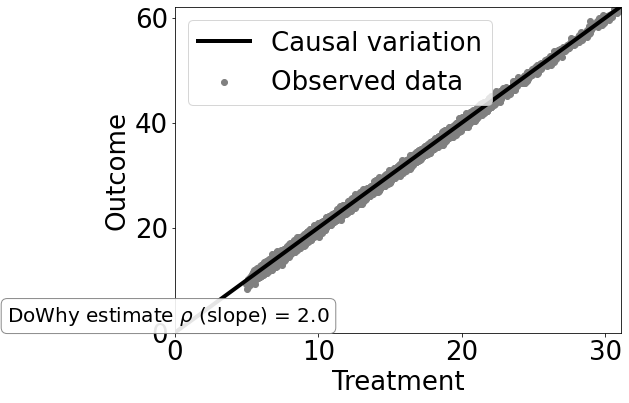

In [13]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between action and outcome = causal effect
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=2, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[Outcome|w1,w0])
d[Treatment]                  
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w1,w0,U) = P(Outcome|Treatment,w1,w0)

## Realized estimand
b: Outcome~Treatment+w1+w0 | 
Target units: ate

## Estimate
Mean value: 1.0125544840534446
Effect estimates: [[1.01255448]]



<h2> 1.4 Check robustness of the estimate using refutation tests </h2>

In [15]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:1.0125544840534446
New effect:1.1042364246531426
p value:0.0



In [16]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:1.0125544840534446
New effect:-0.0002172720896588019
p value:0.35389809636471203

